<a href="https://colab.research.google.com/github/AntonDozhdikov/politpredict/blob/main/DEM_MADDPG_GDM_7_28_89_fin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import time
from datetime import datetime
import copy
import os
from typing import List, Dict, Tuple, Optional

In [ ]:
# Гиперпараметры
NUM_REGIONS_STAGE1 = 7
NUM_REGIONS_STAGE2 = 28
NUM_REGIONS_STAGE3 = 89
EPISODES_PER_STAGE = 42
STEPS = 200
BATCH_SIZE = 64
GAMMA = 0.95
TAU = 0.01
LR_ACTOR = 0.001
LR_CRITIC = 0.002
HIDDEN_SIZE = 64

In [ ]:
# Параметры Darwin Gödel Machine
MUTATION_RATE = 0.1
CROSSOVER_RATE = 0.3
SELECTION_PRESSURE = 0.7
ARCHITECTURE_POOL_SIZE = 100
EVOLUTION_FREQUENCY = 5  # Эволюция каждые 5 эпизодов

In [ ]:
# Обеспечение воспроизводимости
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
class EvolutionLogger:
    """Класс для логирования эволюционного процесса"""
    def __init__(self):
        self.evolution_history = []
        self.architecture_history = []
        self.performance_history = []
        self.mutation_log = []
        self.crossover_log = []
        self.selection_log = []

    def log_evolution_step(self, generation: int, architectures: List,
                          fitness_scores: List, best_score: float):
        """Логирование шага эволюции"""
        step_data = {
            'generation': generation,
            'timestamp': datetime.now().isoformat(),
            'num_architectures': len(architectures),
            'fitness_scores': fitness_scores.copy(),
            'best_fitness': best_score,
            'avg_fitness': np.mean(fitness_scores),
            'fitness_std': np.std(fitness_scores)
        }
        self.evolution_history.append(step_data)

    def log_mutation(self, parent_arch: Dict, mutated_arch: Dict,
                    mutation_type: str):
        """Логирование мутации"""
        mutation_data = {
            'timestamp': datetime.now().isoformat(),
            'mutation_type': mutation_type,
            'parent_hash': hash(str(parent_arch)),
            'mutated_hash': hash(str(mutated_arch)),
            'changes': self._get_architecture_diff(parent_arch, mutated_arch)
        }
        self.mutation_log.append(mutation_data)

    def log_crossover(self, parent1_arch: Dict, parent2_arch: Dict,
                     child_arch: Dict):
        """Логирование скрещивания"""
        crossover_data = {
            'timestamp': datetime.now().isoformat(),
            'parent1_hash': hash(str(parent1_arch)),
            'parent2_hash': hash(str(parent2_arch)),
            'child_hash': hash(str(child_arch))
        }
        self.crossover_log.append(crossover_data)

    def _get_architecture_diff(self, arch1: Dict, arch2: Dict) -> List:
        """Получение различий между архитектурами"""
        differences = []
        for key in arch1:
            if arch1[key] != arch2[key]:
                differences.append({
                    'parameter': key,
                    'old_value': arch1[key],
                    'new_value': arch2[key]
                })
        return differences

    def save_logs(self, filepath: str):
        """Сохранение логов в файл"""
        logs = {
            'evolution_history': self.evolution_history,
            'architecture_history': self.architecture_history,
            'performance_history': self.performance_history,
            'mutation_log': self.mutation_log,
            'crossover_log': self.crossover_log,
            'selection_log': self.selection_log
        }
        with open(filepath, 'w') as f:
            json.dump(logs, f, indent=2)

In [ ]:
class PerformanceMonitor:
    """Класс для мониторинга производительности системы"""
    def __init__(self):
        self.metrics = {
            'episode_rewards': [],
            'system_reward': [],
            'adaptation_speed': [],
            'demographic_stability': [],
            'architecture_entropy': [],
            'computational_complexity': [],
            'energy_efficiency': [],
            'population_balance': [],
            'resource_utilization': [],
            'economic_development': [],
            'policy_coordination': []
        }
        self.start_time = time.time()

    def update_metrics(self, episode: int, agents: List, env_states: np.ndarray,
                      episode_rewards: np.ndarray, architectures: List):
        """Обновление всех метрик"""
        # Основные награды
        self.metrics['episode_rewards'].append(np.mean(episode_rewards))
        self.metrics['system_reward'].append(np.sum(episode_rewards))

        # Демографическая стабильность
        population_var = np.var(env_states[:, 0])
        self.metrics['demographic_stability'].append(1.0 / (1.0 + population_var))

        # Архитектурная энтропия (разнообразие)
        arch_entropy = self._calculate_architecture_entropy(architectures)
        self.metrics['architecture_entropy'].append(arch_entropy)

        # Вычислительная сложность
        complexity = self._calculate_computational_complexity(agents)
        self.metrics['computational_complexity'].append(complexity)

        # Энергоэффективность (награда на параметр)
        efficiency = np.sum(episode_rewards) / (complexity + 1e-8)
        self.metrics['energy_efficiency'].append(efficiency)

        # Специфичные демографические метрики
        self.metrics['population_balance'].append(np.mean(env_states[:, 0]))
        self.metrics['resource_utilization'].append(np.mean(env_states[:, 1]))
        self.metrics['economic_development'].append(np.mean(env_states[:, 2]))
        self.metrics['policy_coordination'].append(1.0 - np.std(env_states[:, 3]))

        # Скорость адаптации
        if len(self.metrics['episode_rewards']) > 10:
            recent_improvement = (np.mean(self.metrics['episode_rewards'][-5:]) -
                                np.mean(self.metrics['episode_rewards'][-10:-5]))
            self.metrics['adaptation_speed'].append(max(0, recent_improvement))
        else:
            self.metrics['adaptation_speed'].append(0)

    def _calculate_architecture_entropy(self, architectures: List) -> float:
        """Вычисление энтропии архитектурного разнообразия"""
        if not architectures:
            return 0.0

        arch_hashes = [hash(str(arch)) for arch in architectures]
        unique_archs = len(set(arch_hashes))
        total_archs = len(arch_hashes)

        if total_archs <= 1:
            return 0.0

        # Энтропия Шеннона
        prob = unique_archs / total_archs
        return -prob * np.log2(prob + 1e-8)

    def _calculate_computational_complexity(self, agents: List) -> float:
        """Вычисление вычислительной сложности"""
        total_params = 0
        for agent in agents:
            if hasattr(agent, 'actor'):
                total_params += sum(p.numel() for p in agent.actor.parameters())
            if hasattr(agent, 'critic'):
                total_params += sum(p.numel() for p in agent.critic.parameters())
        return total_params

    def plot_metrics(self):
        """Построение графиков метрик"""
        fig, axes = plt.subplots(3, 4, figsize=(20, 15))
        fig.suptitle('Мониторинг производительности Darwin Gödel MADDPG', fontsize=16)

        metrics_to_plot = [
            ('episode_rewards', 'Средняя награда за эпизод'),
            ('system_reward', 'Системная награда'),
            ('adaptation_speed', 'Скорость адаптации'),
            ('demographic_stability', 'Демографическая стабильность'),
            ('architecture_entropy', 'Энтропия архитектур'),
            ('computational_complexity', 'Вычислительная сложность'),
            ('energy_efficiency', 'Энергоэффективность'),
            ('population_balance', 'Баланс населения'),
            ('resource_utilization', 'Использование ресурсов'),
            ('economic_development', 'Экономическое развитие'),
            ('policy_coordination', 'Координация политики'),
            ('', '')  # Пустой график
        ]

        for idx, (metric, title) in enumerate(metrics_to_plot):
            row, col = idx // 4, idx % 4
            if metric and metric in self.metrics:
                axes[row, col].plot(self.metrics[metric])
                axes[row, col].set_title(title)
                axes[row, col].grid(True)
            else:
                axes[row, col].set_visible(False)

        plt.tight_layout()
        plt.show()

    def save_metrics(self, filepath: str):
        """Сохранение метрик в файл"""
        with open(filepath, 'w') as f:
            json.dump(self.metrics, f, indent=2)

In [ ]:
class ArchitectureGenome:
    """Класс для представления генома архитектуры нейронной сети"""
    def __init__(self, hidden_sizes: List[int] = None,
                 activation_functions: List[str] = None,
                 dropout_rates: List[float] = None,
                 learning_rate: float = 0.001):
        self.hidden_sizes = hidden_sizes or [64, 32]
        self.activation_functions = activation_functions or ['relu', 'relu']
        self.dropout_rates = dropout_rates or [0.0, 0.0]
        self.learning_rate = learning_rate
        self.fitness = 0.0
        self.age = 0

    def to_dict(self) -> Dict:
        """Преобразование в словарь"""
        return {
            'hidden_sizes': self.hidden_sizes,
            'activation_functions': self.activation_functions,
            'dropout_rates': self.dropout_rates,
            'learning_rate': self.learning_rate,
            'fitness': self.fitness,
            'age': self.age
        }

    @classmethod
    def from_dict(cls, data: Dict):
        """Создание из словаря"""
        genome = cls(
            hidden_sizes=data['hidden_sizes'],
            activation_functions=data['activation_functions'],
            dropout_rates=data['dropout_rates'],
            learning_rate=data['learning_rate']
        )
        genome.fitness = data.get('fitness', 0.0)
        genome.age = data.get('age', 0)
        return genome

    def mutate(self, mutation_rate: float = 0.1) -> 'ArchitectureGenome':
        """Мутация генома"""
        new_genome = copy.deepcopy(self)

        # Мутация размеров скрытых слоев
        if random.random() < mutation_rate:
            layer_idx = random.randint(0, len(new_genome.hidden_sizes) - 1)
            change = random.choice([-16, -8, 8, 16])
            new_genome.hidden_sizes[layer_idx] = max(8,
                                                   new_genome.hidden_sizes[layer_idx] + change)

        # Мутация функций активации
        if random.random() < mutation_rate:
            layer_idx = random.randint(0, len(new_genome.activation_functions) - 1)
            new_genome.activation_functions[layer_idx] = random.choice(
                ['relu', 'tanh', 'sigmoid', 'leaky_relu', 'elu'])

        # Мутация dropout
        if random.random() < mutation_rate:
            layer_idx = random.randint(0, len(new_genome.dropout_rates) - 1)
            new_genome.dropout_rates[layer_idx] = random.uniform(0.0, 0.5)

        # Мутация learning rate
        if random.random() < mutation_rate:
            new_genome.learning_rate *= random.uniform(0.5, 2.0)
            new_genome.learning_rate = max(0.0001, min(0.01, new_genome.learning_rate))

        return new_genome

    def crossover(self, other: 'ArchitectureGenome') -> 'ArchitectureGenome':
        """Скрещивание с другим геномом"""
        new_genome = ArchitectureGenome()

        # Скрещивание размеров слоев
        min_layers = min(len(self.hidden_sizes), len(other.hidden_sizes))
        new_genome.hidden_sizes = []
        for i in range(min_layers):
            if random.random() < 0.5:
                new_genome.hidden_sizes.append(self.hidden_sizes[i])
            else:
                new_genome.hidden_sizes.append(other.hidden_sizes[i])

        # Скрещивание функций активации
        new_genome.activation_functions = []
        for i in range(min_layers):
            if random.random() < 0.5:
                new_genome.activation_functions.append(self.activation_functions[i])
            else:
                new_genome.activation_functions.append(other.activation_functions[i])

        # Скрещивание dropout rates
        new_genome.dropout_rates = []
        for i in range(min_layers):
            if random.random() < 0.5:
                new_genome.dropout_rates.append(self.dropout_rates[i])
            else:
                new_genome.dropout_rates.append(other.dropout_rates[i])

        # Скрещивание learning rate
        new_genome.learning_rate = random.choice([self.learning_rate, other.learning_rate])

        return new_genome

In [ ]:
class EvolvableActor(nn.Module):
    """Эволюционируемый Actor с настраиваемой архитектурой"""
    def __init__(self, input_size: int = 4, genome: ArchitectureGenome = None):
        super().__init__()
        self.genome = genome or ArchitectureGenome()
        self.input_size = input_size

        layers = []
        prev_size = input_size

        for i, (hidden_size, activation, dropout) in enumerate(zip(
            self.genome.hidden_sizes,
            self.genome.activation_functions,
            self.genome.dropout_rates
        )):
            layers.append(nn.Linear(prev_size, hidden_size))

            # Добавление функции активации
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            elif activation == 'sigmoid':
                layers.append(nn.Sigmoid())
            elif activation == 'leaky_relu':
                layers.append(nn.LeakyReLU())
            elif activation == 'elu':
                layers.append(nn.ELU())

            # Добавление dropout
            if dropout > 0:
                layers.append(nn.Dropout(dropout))

            prev_size = hidden_size

        # Выходной слой
        layers.append(nn.Linear(prev_size, 1))
        layers.append(nn.Tanh())

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


In [ ]:
class EvolvableCritic(nn.Module):
    """Эволюционируемый Critic с настраиваемой архитектурой"""
    def __init__(self, total_regions: int, genome: ArchitectureGenome = None):
        super().__init__()
        self.genome = genome or ArchitectureGenome()
        self.total_regions = total_regions
        input_size = 4 * total_regions + total_regions

        layers = []
        prev_size = input_size

        for i, (hidden_size, activation, dropout) in enumerate(zip(
            self.genome.hidden_sizes,
            self.genome.activation_functions,
            self.genome.dropout_rates
        )):
            layers.append(nn.Linear(prev_size, hidden_size))

            # Добавление функции активации
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            elif activation == 'sigmoid':
                layers.append(nn.Sigmoid())
            elif activation == 'leaky_relu':
                layers.append(nn.LeakyReLU())
            elif activation == 'elu':
                layers.append(nn.ELU())

            # Добавление dropout
            if dropout > 0:
                layers.append(nn.Dropout(dropout))

            prev_size = hidden_size

        # Выходной слой
        layers.append(nn.Linear(prev_size, 1))

        self.net = nn.Sequential(*layers)

    def forward(self, states, actions):
        x = torch.cat([states.flatten(1), actions.flatten(1)], dim=1)
        return self.net(x)


In [ ]:
class DarwinGodelAgent:
    """Агент с возможностью эволюции архитектуры"""
    def __init__(self, agent_id: int, total_regions: int,
                 actor_genome: ArchitectureGenome = None,
                 critic_genome: ArchitectureGenome = None,
                 is_base: bool = False):
        self.agent_id = agent_id
        self.total_regions = total_regions
        self.is_base = is_base

        # Создание геномов если не переданы
        self.actor_genome = actor_genome or ArchitectureGenome()
        self.critic_genome = critic_genome or ArchitectureGenome()

        # Создание сетей на основе геномов
        self.actor = EvolvableActor(genome=self.actor_genome)
        self.actor_target = EvolvableActor(genome=self.actor_genome)
        self.critic = EvolvableCritic(total_regions, genome=self.critic_genome)
        self.critic_target = EvolvableCritic(total_regions, genome=self.critic_genome)

        # Оптимизаторы с учетом learning rate из генома
        self.actor_optim = optim.Adam(self.actor.parameters(),
                                    lr=self.actor_genome.learning_rate)
        self.critic_optim = optim.Adam(self.critic.parameters(),
                                     lr=self.critic_genome.learning_rate)

        # Копирование весов в target сети
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.critic_target.load_state_dict(self.critic.state_dict())

        self.steps_done = 0
        self.fitness_history = []

    def act(self, state, exploration=True):
        """Выбор действия агентом"""
        with torch.no_grad():
            action = self.actor(torch.FloatTensor(state)).numpy()
            if exploration and not self.is_base:
                # Адаптивный шум на основе fitness
                noise_scale = 0.1 * max(0, 1 - self.steps_done / 10000)
                if self.fitness_history:
                    # Больше шума для агентов с низким fitness
                    avg_fitness = np.mean(self.fitness_history[-10:])
                    noise_scale *= (2.0 - min(1.0, max(0.0, avg_fitness)))
                noise = np.random.normal(0, noise_scale)
                action += noise
            return np.clip(action, -1, 1)

    def update_fitness(self, reward: float):
        """Обновление fitness агента"""
        self.fitness_history.append(reward)
        if len(self.fitness_history) > 100:
            self.fitness_history.pop(0)

        # Обновляем fitness в геномах
        recent_fitness = np.mean(self.fitness_history[-10:]) if self.fitness_history else 0
        self.actor_genome.fitness = recent_fitness
        self.critic_genome.fitness = recent_fitness

    def evolve_architecture(self, best_actor_genome: ArchitectureGenome = None,
                          best_critic_genome: ArchitectureGenome = None):
        """Эволюция архитектуры агента"""
        if self.is_base:
            return False  # Базовые агенты не эволюционируют

        evolved = False

        # Эволюция Actor
        if best_actor_genome and random.random() < CROSSOVER_RATE:
            new_actor_genome = self.actor_genome.crossover(best_actor_genome)
            evolved = True
        else:
            new_actor_genome = self.actor_genome.mutate(MUTATION_RATE)
            evolved = new_actor_genome.to_dict() != self.actor_genome.to_dict()

        # Эволюция Critic
        if best_critic_genome and random.random() < CROSSOVER_RATE:
            new_critic_genome = self.critic_genome.crossover(best_critic_genome)
            evolved = True
        else:
            new_critic_genome = self.critic_genome.mutate(MUTATION_RATE)
            evolved = evolved or (new_critic_genome.to_dict() != self.critic_genome.to_dict())

        if evolved:
            # Сохраняем старые веса для потенциального восстановления
            old_actor_state = self.actor.state_dict()
            old_critic_state = self.critic.state_dict()

            # Создаем новые сети
            self.actor_genome = new_actor_genome
            self.critic_genome = new_critic_genome

            new_actor = EvolvableActor(genome=self.actor_genome)
            new_critic = EvolvableCritic(self.total_regions, genome=self.critic_genome)

            # Пытаемся перенести веса (частично, если возможно)
            try:
                self._transfer_weights(self.actor, new_actor)
                self._transfer_weights(self.critic, new_critic)
            except:
                pass  # Если не удается перенести, начинаем с случайных весов

            self.actor = new_actor
            self.critic = new_critic

            # Обновляем target сети
            self.actor_target = EvolvableActor(genome=self.actor_genome)
            self.critic_target = EvolvableCritic(self.total_regions, genome=self.critic_genome)
            self.actor_target.load_state_dict(self.actor.state_dict())
            self.critic_target.load_state_dict(self.critic.state_dict())

            # Обновляем оптимизаторы
            self.actor_optim = optim.Adam(self.actor.parameters(),
                                        lr=self.actor_genome.learning_rate)
            self.critic_optim = optim.Adam(self.critic.parameters(),
                                         lr=self.critic_genome.learning_rate)

        return evolved

    def _transfer_weights(self, old_net, new_net):
        """Перенос весов между сетями разной архитектуры"""
        old_state = old_net.state_dict()
        new_state = new_net.state_dict()

        for name, param in new_state.items():
            if name in old_state:
                old_param = old_state[name]
                if old_param.shape == param.shape:
                    new_state[name] = old_param

        new_net.load_state_dict(new_state)

In [ ]:
class MigrationEnvironment:
    """Среда для моделирования миграционных процессов"""
    def __init__(self, num_regions=NUM_REGIONS_STAGE1):
        self.num_regions = num_regions
        self.reset()

    def reset(self):
        """Сброс среды"""
        self.states = np.random.uniform(0.5, 1.5, (self.num_regions, 4))
        self.states[:, 3] = 0.0  # Политика миграции
        return self.states.copy()

    def step(self, actions):
        """Выполнение шага в среде"""
        next_states = np.zeros_like(self.states)
        rewards = np.zeros(self.num_regions)

        for i in range(self.num_regions):
            # Обновление политики миграции
            self.states[i, 3] = np.clip(self.states[i, 3] + actions[i][0], -1, 1)

            # Вычисление миграции
            neighbor_policies = [self.states[j, 3] for j in self.neighbors(i)]
            migration = 0.1 * (self.states[i, 3] - np.mean(neighbor_policies))

            # Обновление численности населения
            self.states[i, 0] = np.clip(self.states[i, 0] + migration, 0.1, 2.0)

            # Экономический рост
            economic_growth = 0.05 * self.states[i, 0] * (1 + self.states[i, 3])
            self.states[i, 2] = np.clip(self.states[i, 2] + economic_growth, 0.1, 2.0)

            # Использование ресурсов
            resource_usage = 0.02 * self.states[i, 0] * self.states[i, 2]
            self.states[i, 1] = np.clip(self.states[i, 1] - resource_usage, 0.1, 2.0)

            # Вычисление награды
            rewards[i] = self._calculate_reward(i)

        return self.states.copy(), rewards, False, {}

    def _calculate_reward(self, region):
        """Вычисление награды для региона"""
        pop_balance = -abs(self.states[region, 0] - 1.0)
        economy = self.states[region, 2] - 1.0
        resources = -0.5 * (1.0 - self.states[region, 1])

        neighbor_policies = [self.states[j, 3] for j in self.neighbors(region)]
        policy_align = 0.2 * np.mean([1 - abs(self.states[region, 3] - policy)
                                    for policy in neighbor_policies])

        return pop_balance + economy + resources + policy_align

    def neighbors(self, region):
        """Получение соседей региона"""
        return [(region - 1) % self.num_regions, (region + 1) % self.num_regions]

In [ ]:
class DarwinGodelMADDPG:
    """Основной класс системы с интеграцией Darwin Gödel Machine и MADDPG"""
    def __init__(self, num_regions=NUM_REGIONS_STAGE1, prev_agents=None):
        self.num_regions = num_regions
        self.env = MigrationEnvironment(num_regions)
        self.evolution_logger = EvolutionLogger()
        self.performance_monitor = PerformanceMonitor()

        # Инициализация агентов
        if prev_agents:
            self.agents = prev_agents
            for agent in self.agents:
                agent.is_base = True
            self._add_new_agents(num_regions - len(prev_agents))
        else:
            self.agents = [DarwinGodelAgent(i, num_regions) for i in range(num_regions)]

        self.memory = deque(maxlen=100000)
        self.generation = 0
        self.best_architectures = {
            'actor': None,
            'critic': None
        }

    def _add_new_agents(self, num_new):
        """Добавление новых агентов"""
        for i in range(num_new):
            base_agent = self.agents[i % len(self.agents)]
            new_agent = DarwinGodelAgent(
                len(self.agents),
                self.num_regions,
                actor_genome=copy.deepcopy(base_agent.actor_genome),
                critic_genome=copy.deepcopy(base_agent.critic_genome)
            )
            self.agents.append(new_agent)

    def train_stage(self, episodes, stage_name):
        """Обучение на определенной стадии"""
        print(f"\n=== {stage_name} ===")
        print(f"Количество агентов: {len(self.agents)}")
        print(f"Количество эпизодов: {episodes}")

        for episode in range(episodes):
            states = self.env.reset()
            episode_rewards = np.zeros(self.num_regions)

            for step in range(STEPS):
                # Получение действий от агентов
                actions = self._get_actions(states)

                # Выполнение шага в среде
                next_states, rewards, _, _ = self.env.step(actions)

                # Сохранение опыта
                self.memory.append((states, actions, rewards, next_states))

                # Обновление агентов
                if len(self.memory) > BATCH_SIZE:
                    self._update_agents()

                # Обновление fitness агентов
                for i, agent in enumerate(self.agents):
                    agent.update_fitness(rewards[i])
                    if not agent.is_base:
                        agent.steps_done += 1

                episode_rewards += rewards
                states = next_states

            # Эволюция архитектур
            if episode % EVOLUTION_FREQUENCY == 0 and episode > 0:
                self._evolve_population()

            # Обновление мониторинга
            architectures = [agent.actor_genome.to_dict() for agent in self.agents]
            self.performance_monitor.update_metrics(
                episode, self.agents, states, episode_rewards, architectures)

            # Вывод прогресса
            avg_reward = np.mean(episode_rewards)
            if episode % 10 == 0:
                print(f"Эпизод {episode + 1}, Средняя награда: {avg_reward:.3f}, "
                      f"Системная награда: {np.sum(episode_rewards):.3f}")

        print(f"{stage_name} завершена!")

    def _get_actions(self, states):
        """Получение действий от всех агентов"""
        actions = []
        for i, agent in enumerate(self.agents):
            exploration = not agent.is_base
            action = agent.act(states[i], exploration=exploration)
            actions.append(action)
        return actions

    def _update_agents(self):
        """Обновление агентов методом MADDPG"""
        batch = random.sample(self.memory, BATCH_SIZE)

        states = torch.FloatTensor(np.array([item[0] for item in batch]))
        actions = torch.FloatTensor(np.array([item[1] for item in batch]))
        rewards = torch.FloatTensor(np.array([item[2] for item in batch]))
        next_states = torch.FloatTensor(np.array([item[3] for item in batch]))

        for idx, agent in enumerate(self.agents):
            if agent.is_base:
                continue

            # Обновление Critic
            agent.critic_optim.zero_grad()

            with torch.no_grad():
                target_actions = []
                for i, a in enumerate(self.agents):
                    target_action = a.actor_target(next_states[:, i, :])
                    target_actions.append(target_action)

                target_q = rewards[:, idx] + GAMMA * agent.critic_target(
                    next_states.view(BATCH_SIZE, -1),
                    torch.cat(target_actions, dim=1)
                ).squeeze()

            current_q = agent.critic(
                states.view(BATCH_SIZE, -1),
                actions.view(BATCH_SIZE, -1)
            ).squeeze()

            critic_loss = nn.MSELoss()(current_q, target_q)
            critic_loss.backward()
            torch.nn.utils.clip_grad_norm_(agent.critic.parameters(), 1.0)
            agent.critic_optim.step()

            # Обновление Actor
            agent.actor_optim.zero_grad()

            policy_actions = []
            for i, a in enumerate(self.agents):
                if i == idx:
                    policy_actions.append(agent.actor(states[:, i, :]))
                else:
                    policy_actions.append(a.actor(states[:, i, :]).detach())

            actor_loss = -agent.critic(
                states.view(BATCH_SIZE, -1),
                torch.cat(policy_actions, dim=1)
            ).mean()

            actor_loss.backward()
            torch.nn.utils.clip_grad_norm_(agent.actor.parameters(), 1.0)
            agent.actor_optim.step()

            # Обновление target сетей
            self._soft_update(agent.actor, agent.actor_target, TAU)
            self._soft_update(agent.critic, agent.critic_target, TAU)

    def _soft_update(self, source, target, tau):
        """Мягкое обновление target сети"""
        for target_param, source_param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(tau * source_param.data + (1.0 - tau) * target_param.data)

    def _evolve_population(self):
        """Эволюция популяции агентов"""
        print(f"\n--- Эволюция поколения {self.generation} ---")

        # Сбор fitness scores
        fitness_scores = []
        actor_genomes = []
        critic_genomes = []

        for agent in self.agents:
            if not agent.is_base:
                fitness = np.mean(agent.fitness_history[-10:]) if agent.fitness_history else 0
                fitness_scores.append(fitness)
                actor_genomes.append(agent.actor_genome)
                critic_genomes.append(agent.critic_genome)

        if not fitness_scores:
            return

        # Найти лучшие архитектуры
        best_idx = np.argmax(fitness_scores)
        best_actor_genome = actor_genomes[best_idx]
        best_critic_genome = critic_genomes[best_idx]

        # Обновить глобальные лучшие архитектуры
        if (self.best_architectures['actor'] is None or
            best_actor_genome.fitness > self.best_architectures['actor'].fitness):
            self.best_architectures['actor'] = copy.deepcopy(best_actor_genome)

        if (self.best_architectures['critic'] is None or
            best_critic_genome.fitness > self.best_architectures['critic'].fitness):
            self.best_architectures['critic'] = copy.deepcopy(best_critic_genome)

        # Логирование эволюции
        self.evolution_logger.log_evolution_step(
            self.generation,
            [g.to_dict() for g in actor_genomes],
            fitness_scores,
            np.max(fitness_scores)
        )

        # Эволюция агентов
        evolved_count = 0
        for agent in self.agents:
            if agent.is_base:
                continue

            old_actor_genome = copy.deepcopy(agent.actor_genome)
            old_critic_genome = copy.deepcopy(agent.critic_genome)

            evolved = agent.evolve_architecture(
                self.best_architectures['actor'],
                self.best_architectures['critic']
            )

            if evolved:
                evolved_count += 1
                # Логирование мутаций/скрещиваний
                if random.random() < 0.5:  # Предполагаем что была мутация
                    self.evolution_logger.log_mutation(
                        old_actor_genome.to_dict(),
                        agent.actor_genome.to_dict(),
                        "actor_mutation"
                    )
                else:  # Предполагаем скрещивание
                    self.evolution_logger.log_crossover(
                        old_actor_genome.to_dict(),
                        self.best_architectures['actor'].to_dict(),
                        agent.actor_genome.to_dict()
                    )

        print(f"Эволюционировало агентов: {evolved_count}")
        print(f"Лучший fitness: {np.max(fitness_scores):.3f}")
        print(f"Средний fitness: {np.mean(fitness_scores):.3f}")

        self.generation += 1

    def train_all_stages(self):
        """Обучение всех стадий"""
        # Стадия 1: 7 агентов
        self.train_stage(EPISODES_PER_STAGE, "Стадия 1: 7 агентов")

        # Расширение до 28 агентов
        stage1_agents = copy.deepcopy(self.agents)
        self.__init__(NUM_REGIONS_STAGE2, stage1_agents)
        self.train_stage(EPISODES_PER_STAGE, "Стадия 2: 28 агентов")

        # Расширение до 89 агентов
        stage2_agents = copy.deepcopy(self.agents)
        self.__init__(NUM_REGIONS_STAGE3, stage2_agents)
        self.train_stage(EPISODES_PER_STAGE, "Стадия 3: 89 агентов")

        # Построение финальных графиков
        self.plot_final_results()

    def plot_final_results(self):
        """Построение финальных результатов"""
        print("\n=== Построение финальных графиков ===")

        # График метрик производительности
        self.performance_monitor.plot_metrics()

        # График эволюции fitness
        if self.evolution_logger.evolution_history:
            plt.figure(figsize=(12, 6))

            generations = [step['generation'] for step in self.evolution_logger.evolution_history]
            best_fitness = [step['best_fitness'] for step in self.evolution_logger.evolution_history]
            avg_fitness = [step['avg_fitness'] for step in self.evolution_logger.evolution_history]

            plt.subplot(1, 2, 1)
            plt.plot(generations, best_fitness, 'r-', label='Лучший fitness', linewidth=2)
            plt.plot(generations, avg_fitness, 'b-', label='Средний fitness', linewidth=2)
            plt.xlabel('Поколение')
            plt.ylabel('Fitness')
            plt.title('Эволюция Fitness по поколениям')
            plt.legend()
            plt.grid(True)

            # Гистограмма типов мутаций
            plt.subplot(1, 2, 2)
            mutation_types = [log['mutation_type'] for log in self.evolution_logger.mutation_log]
            if mutation_types:
                mutation_counts = {}
                for mut_type in mutation_types:
                    mutation_counts[mut_type] = mutation_counts.get(mut_type, 0) + 1

                types = list(mutation_counts.keys())
                counts = list(mutation_counts.values())

                plt.bar(types, counts)
                plt.xlabel('Тип мутации')
                plt.ylabel('Количество')
                plt.title('Распределение типов мутаций')
                plt.xticks(rotation=45)

            plt.tight_layout()
            plt.show()

        # Сохранение результатов
        self.save_results()

    def save_results(self):
        """Сохранение всех результатов"""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        results_dir = f"darwin_godel_results_{timestamp}"
        os.makedirs(results_dir, exist_ok=True)

        # Сохранение агентов
        agents_data = []
        for i, agent in enumerate(self.agents):
            agent_data = {
                'agent_id': agent.agent_id,
                'is_base': agent.is_base,
                'actor_genome': agent.actor_genome.to_dict(),
                'critic_genome': agent.critic_genome.to_dict(),
                'fitness_history': agent.fitness_history,
                'actor_state_dict': agent.actor.state_dict(),
                'critic_state_dict': agent.critic.state_dict()
            }
            agents_data.append(agent_data)

        with open(f"{results_dir}/agents.pkl", 'wb') as f:
            pickle.dump(agents_data, f)

        # Сохранение логов эволюции
        self.evolution_logger.save_logs(f"{results_dir}/evolution_logs.json")

        # Сохранение метрик производительности
        self.performance_monitor.save_metrics(f"{results_dir}/performance_metrics.json")

        # Сохранение лучших архитектур
        best_architectures = {
            'actor': self.best_architectures['actor'].to_dict() if self.best_architectures['actor'] else None,
            'critic': self.best_architectures['critic'].to_dict() if self.best_architectures['critic'] else None
        }

        with open(f"{results_dir}/best_architectures.json", 'w') as f:
            json.dump(best_architectures, f, indent=2)

        print(f"Результаты сохранены в директории: {results_dir}")

=== Эксперимент Darwin Gödel MADDPG ===
Система управления демографическими процессами
с эволюционной адаптацией архитектур


=== Стадия 1: 7 агентов ===
Количество агентов: 7
Количество эпизодов: 42
Эпизод 1, Средняя награда: -93.976, Системная награда: -657.830

--- Эволюция поколения 0 ---
Эволюционировало агентов: 6
Лучший fitness: 0.712
Средний fitness: 0.510

--- Эволюция поколения 1 ---
Эволюционировало агентов: 5
Лучший fitness: 0.748
Средний fitness: 0.532
Эпизод 11, Средняя награда: 112.034, Системная награда: 784.240

--- Эволюция поколения 2 ---
Эволюционировало агентов: 6
Лучший fitness: 0.706
Средний fitness: 0.341

--- Эволюция поколения 3 ---
Эволюционировало агентов: 7
Лучший fitness: 0.697
Средний fitness: 0.582
Эпизод 21, Средняя награда: 116.990, Системная награда: 818.928

--- Эволюция поколения 4 ---
Эволюционировало агентов: 3
Лучший fitness: 0.743
Средний fitness: 0.496

--- Эволюция поколения 5 ---
Эволюционировало агентов: 4
Лучший fitness: 0.641
Средний fitne

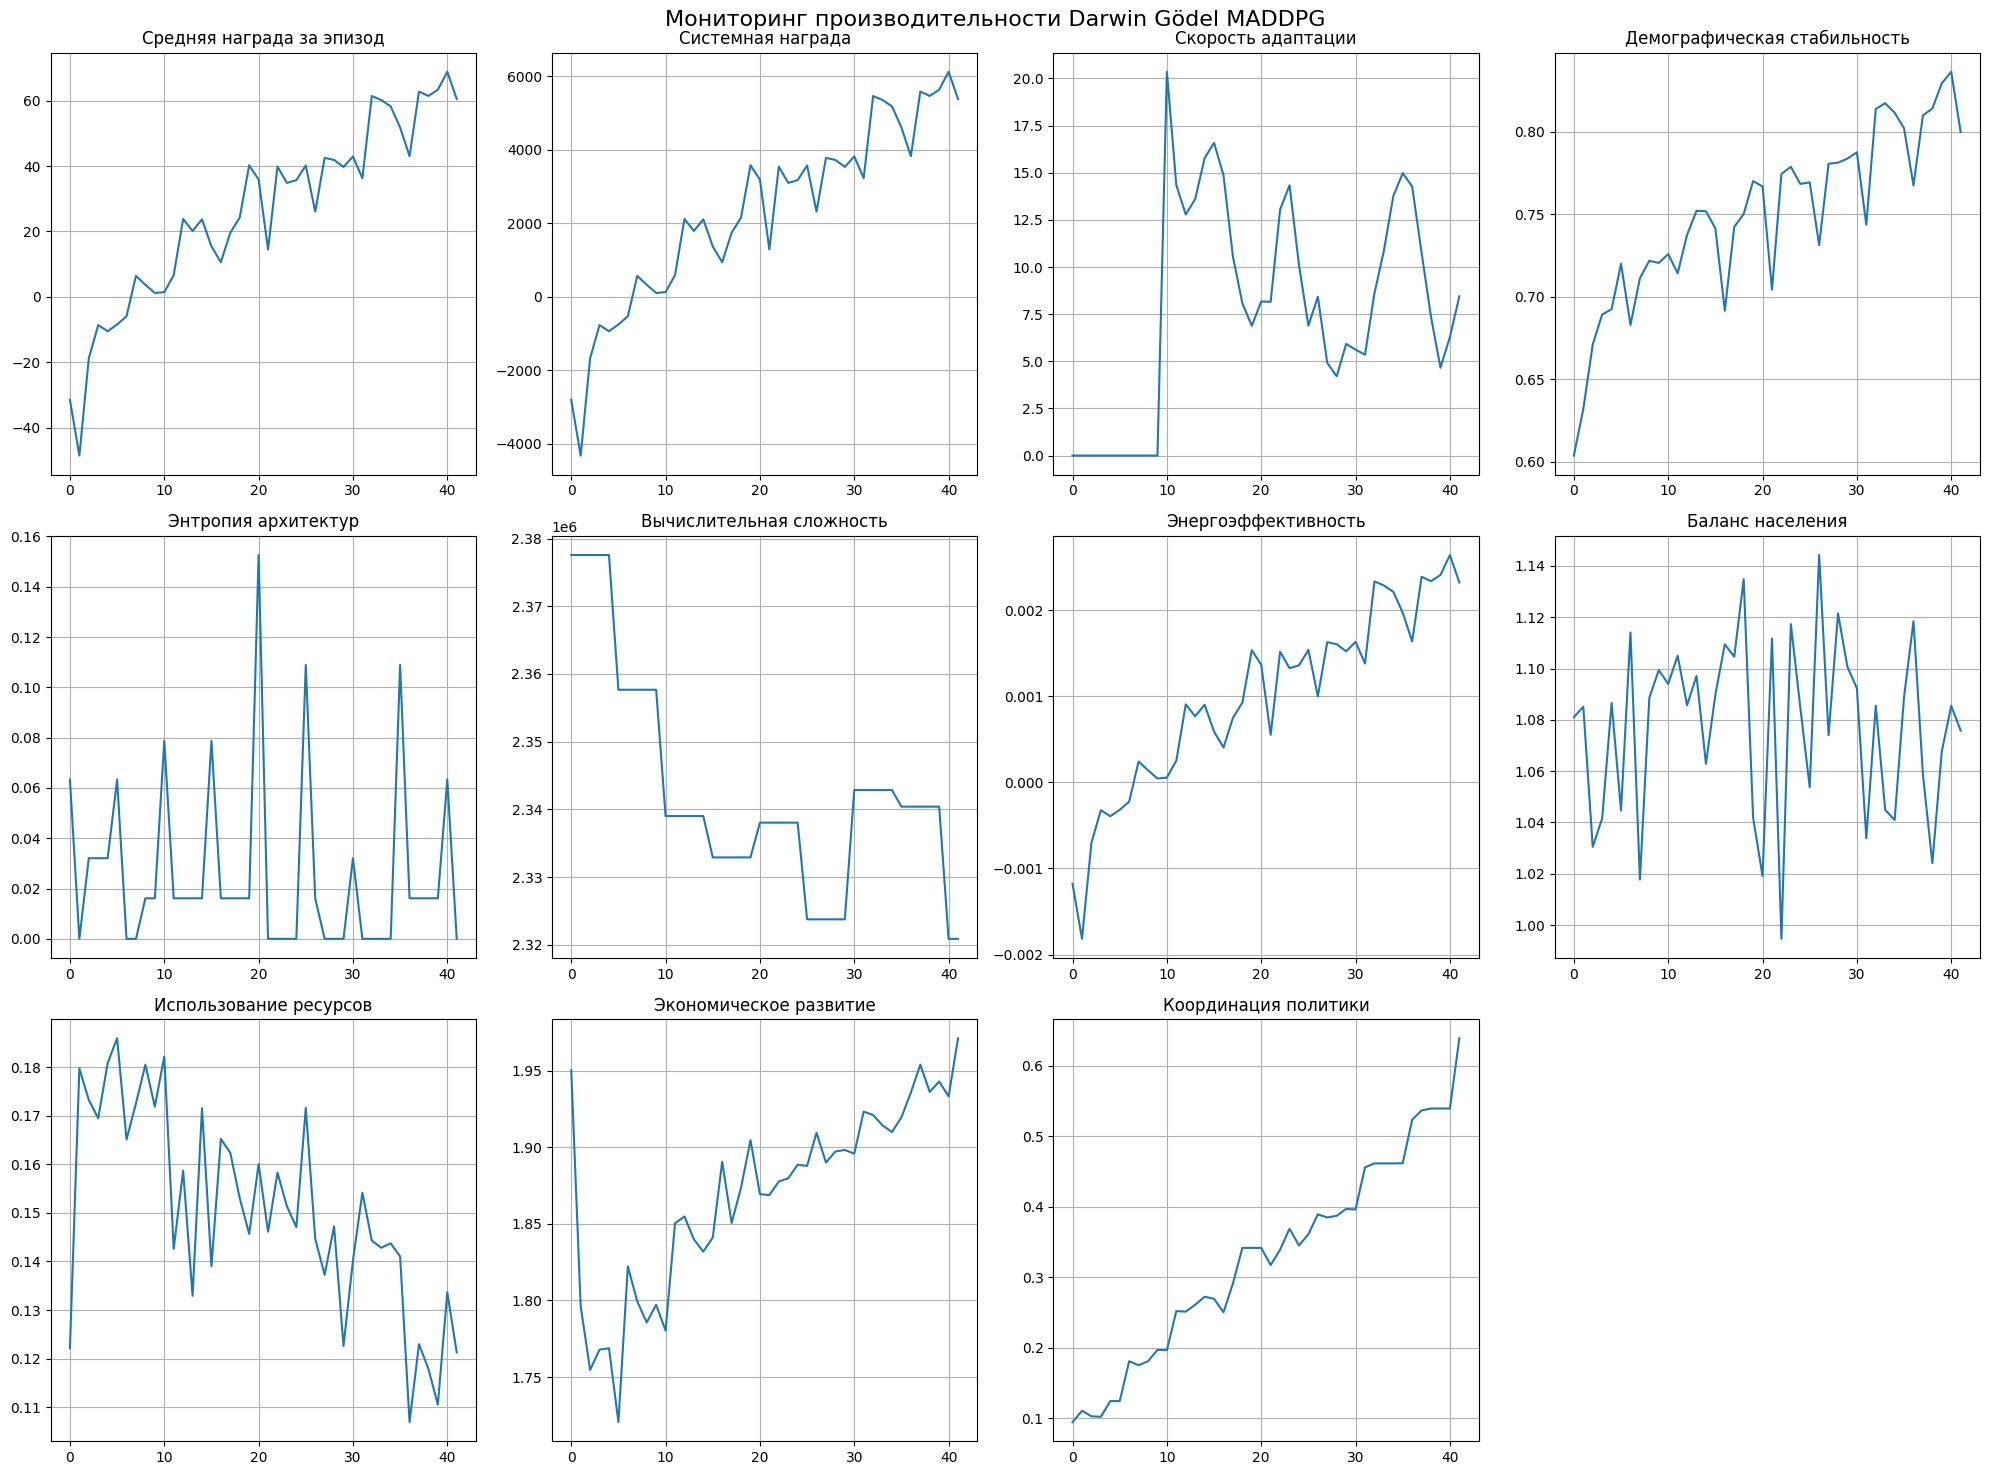

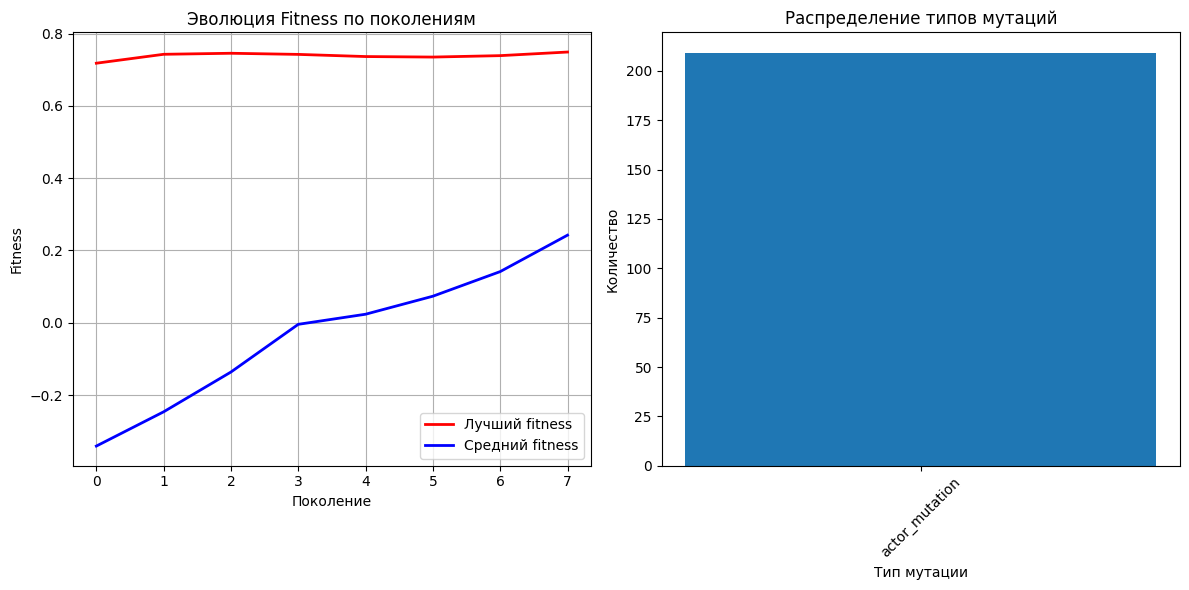

Результаты сохранены в директории: darwin_godel_results_20250610_152128

=== Эксперимент успешно завершен! ===


In [13]:
# Запуск эксперимента
if __name__ == "__main__":
    print("=== Эксперимент Darwin Gödel MADDPG ===")
    print("Система управления демографическими процессами")
    print("с эволюционной адаптацией архитектур\n")

    # Создание и запуск системы
    system = DarwinGodelMADDPG()

    try:
        system.train_all_stages()
        print("\n=== Эксперимент успешно завершен! ===")

    except KeyboardInterrupt:
        print("\n=== Эксперимент прерван пользователем ===")
        system.save_results()

    except Exception as e:
        print(f"\n=== Ошибка в эксперименте: {e} ===")
        system.save_results()
        raise